## Tutorial 4: 2D Wave Equation and Convection-Diffusion Equation

This tutorial intends to facilitate the application of the implicit methods discussed previously by using the class __IterativeMethod__. It is very important to note that __IterativeMethod__ is not part of the core Devito code. This class should serve as an example for one possible implementation of the implicit methods discussed in the previous tutorials for problems that have a time dimension.

The target problems for the implicit solver are:

1. The two-dimensional wave equation:

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = 0$$

2. The two-dimensional convection-diffusion equation:

$$\frac{\partial u}{\partial t} + a \biggl(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y}\biggr) = b \biggl(\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2}\biggr)$$

First, the __Grid__ is defined, which will contain the numerical values for $u$ in the domain, and also the __TimeFunction__, which is the symbolic representation of the variable $u$ inside Devito.

In [1]:
from devito import Grid, TimeFunction

shape = (50, 50)   # Grid size in number of points
extent = (1., 1.)  # Grid size in meters

grid = Grid(shape = shape, extent = extent) # The spatial grid matrix

# The symbolic representation of the wave function
u1 = TimeFunction(name = 'u', grid = grid, space_order = 1)

# The symbolic representation of the convection-diffusion function
u2 = TimeFunction(name = 'u', grid = grid, space_order = 2)

When working with the wave equation, the parameter $\lambda = \frac{dt}{dx}$ must be chosen such that the numerical scheme used afterwards is stable. It is sufficient to choose $|max(c, v) \cdot \lambda| \leq 1$, respecting the CFL condition. Also note that the value of the velocity $c$ in the $x$ direction is 10 times less than the velocity $v$ in the $y$ direction.

The Forward-Time Central-Space scheme for the convection-diffusion equation is stable whenever $b \mu \leq \frac{1}{2}$, with $\mu = \frac{dt}{dx^2}$. Let $h$ be the grid spacing, then the condition $h \leq \frac{2 b}{a}$ must also be satisffied for the solution to be adequate($\mathrm{Strikwerda^{[1]}}$ page 157,158).

$\mathrm{^{[1]}}$ __Strikwerda, J.C., 2004. Finite difference schemes and partial differential equations (Vol. 88). Siam.__ 

In [2]:
c, v = 0.1, 1      # Velocities for the waves
a, b = 0.1, 0.01   # Convection and diffusion terms
Lambda = 0.2       # Lambda = dt / dx = dt / dy

dx = extent[0] / (shape[0] - 1) # The spatial step in the x direction
dy = extent[1] / (shape[1] - 1) # The spatial step in the y direction
dt = Lambda * dx                # The time step

tf = 0.1            # The final time is 0.1 seconds
time = int(tf / dt) # The number of steps necessary to reach the final time

hx = grid.spacing[0]
mu = dt / dx ** 2

assert abs(max(c, v)) * Lambda <= 1, "Unstable scheme for the wave equation"
assert mu * b <= 0.5, "Unstable scheme for the convection-diffusion equation"
assert hx * a <= 2 * b, "Unadequate scheme for the convection-diffusion equation"

Next, the initial condition is applied to the grid data and plotted. The initial condition is chosen to be zero at almost all the domain, except for a square that fills the central part of the domain, as can be seen after the execution of the code below.

Since the velocity $v$ is 10 times bigger than the velocity $c$, it makes sense to use a more stable numerical scheme to handle the $y$ direction, hence the usage of implicit methods. The diffusion term in the convection-diffusion equation also benefits from the usage of an implicit approach.

Suppose we have a differential equation $\frac{\partial u}{\partial t} = A(u) + B(u)$, where $A(u)$ represent stiff terms, which must be handled implicitly, and $B(u)$ are nonstiff, which can be handled explicitly. Using the combined forward euler and backward euler, the final equation becomes $\frac{\partial u}{\partial t} = A(u(t+\Delta t)) + B(u(t))$.

For the wave equation, $A(u) = v \frac{\partial u}{\partial y}$ and $B(u) = c \frac{\partial u}{\partial x}$, with $v >> c$.

For the convection-diffusion equation, $A(u) = a \biggl(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y}\biggr)$ and $B(u) = b \biggl(\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2}\biggr)$

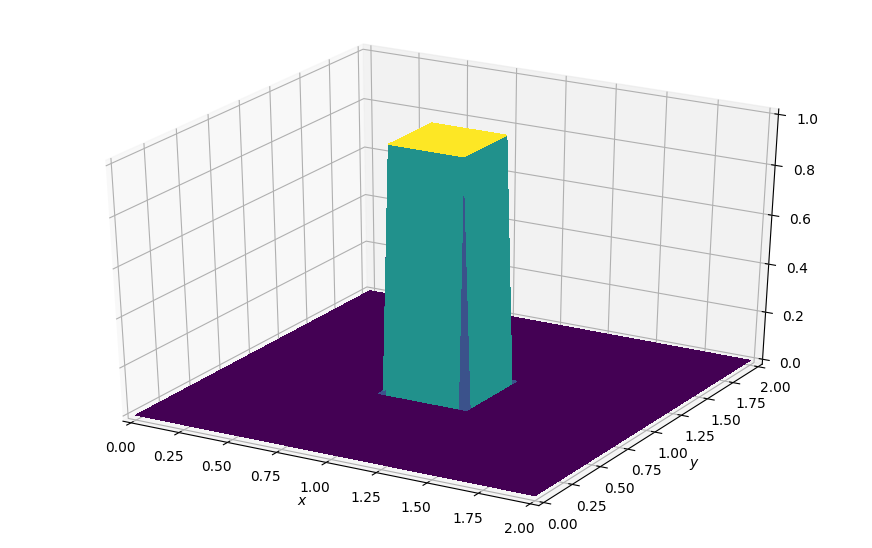

In [3]:
import numpy as np

def u0(u): # Define the initial condition for 'u'
    tempx, tempy = int(0.2 * shape[0]), int(0.2 * shape[1])

    u.data[0][2*tempx:3*tempx, 2*tempy:3*tempy] = 1
    u.data[1] = u.data[0]
    
from examples.cfd import plot_field

u = TimeFunction(name = 'u', grid = grid)

u0(u)                 # Apply the initial condition
plot_field(u.data[0]) # Plot the initial condition

In [4]:
from devito import Eq

# Note: The discretization used is backward in space ("dxl", "dyl") for the wave equation
wavePDE = Eq(u1.dt + c*u1.dxl + v*u1.forward.dyl)

wavePDE.evaluate

Eq(u(t + dt, x, y)/h_y - u(t + dt, x, y - h_y)/h_y + 0.1*u(t, x, y)/h_x - 0.1*u(t, x - h_x, y)/h_x - u(t, x, y)/dt + u(t + dt, x, y)/dt, 0)

In [5]:
# Note: The discretization used is central in space ("dxc", "dyc") for the convection-diffusion equation
diffusionPDE = Eq(u2.dt + a * (u2.dxc + u2.dyc), b * u2.forward.laplace)

diffusionPDE.evaluate

Eq(-0.05*u(t, x, y - h_y)/h_y + 0.05*u(t, x, y + h_y)/h_y - 0.05*u(t, x - h_x, y)/h_x + 0.05*u(t, x + h_x, y)/h_x - u(t, x, y)/dt + u(t + dt, x, y)/dt, -0.02*u(t + dt, x, y)/h_y**2 + 0.01*u(t + dt, x, y - h_y)/h_y**2 + 0.01*u(t + dt, x, y + h_y)/h_y**2 - 0.02*u(t + dt, x, y)/h_x**2 + 0.01*u(t + dt, x - h_x, y)/h_x**2 + 0.01*u(t + dt, x + h_x, y)/h_x**2)

The class __IterativeMethod__ is responsible for creating a set of explicit equations, which can be interpreted by Devito, whereas equations with more than one term in the left hand side cannot. These explicit equations is the result of applying an iterative algorithm like, for example, the SOR (Successive Over-Relaxation). For a more descriptive explanation on how the class __IterativeMethod__ works, look for the previous tutorials about the Poisson equation, where the implicit equations are converted into explicit ones by hand.

The linear solver utilized is SOR (Successive Over-Relaxation) and the default value of $\omega$ is the optimal for the Poisson problem $\omega_{opt} \approx 2 - 2 \pi h$, which is OK for the diffusion problem. For the wave equation, we will set $\omega = 1.5$. The residual criteria is $|u_{n+1}-u_n|^p < \epsilon$. Look for the documentation of the method "set_constant" to see a list of possible configuration parameters for each implicit method.

In [6]:
# Note: The PDEs are redeclared here to avoid problems with sympy.cache.clear_cache,
#       which is called when accessing u.data in further cells.
wavePDE = Eq(u1.dt + c*u1.dxl + v*u1.forward.dyl)
diffusionPDE = Eq(u2.dt + a * (u2.dxc + u2.dyc), b * u2.forward.laplace)

from devito import configuration
from examples.implicit import IterativeMethod

configuration['loop-splitting'] = False
configuration['language'] = 'openmp' # Enables OpenMP parallelization

# Set the parameters for the iterative algorithm (SOR)
IterativeMethod.SOR.set_constant('epsilon', 0.01) # SOR tolerance

diffusionEqs = IterativeMethod.SOR.explicit_expressions(diffusionPDE)

IterativeMethod.SOR.set_constant('omega', 1.5)
waveEqs = IterativeMethod.SOR.explicit_expressions(wavePDE)

The final step is to create and run the __Operator__ responsible for solving the PDEs.

In [7]:
from devito import Operator

waveOp = Operator(waveEqs)
diffusionOp = Operator(diffusionEqs)

Operator `Kernel` run in 0.03 s


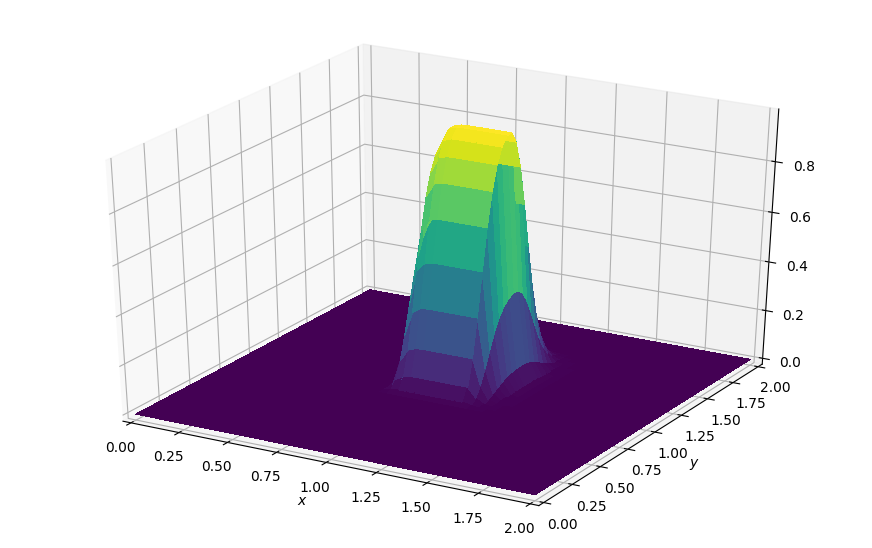

In [8]:
u0(u1) # Reapply the initial condition
waveOp(time = time, dt = dt, iter_m = 1, iter_M = 10) # Run the operator

plot_field(u1.data[0, :, :]) # Plot the result for the wave equation

Operator `Kernel` run in 0.02 s


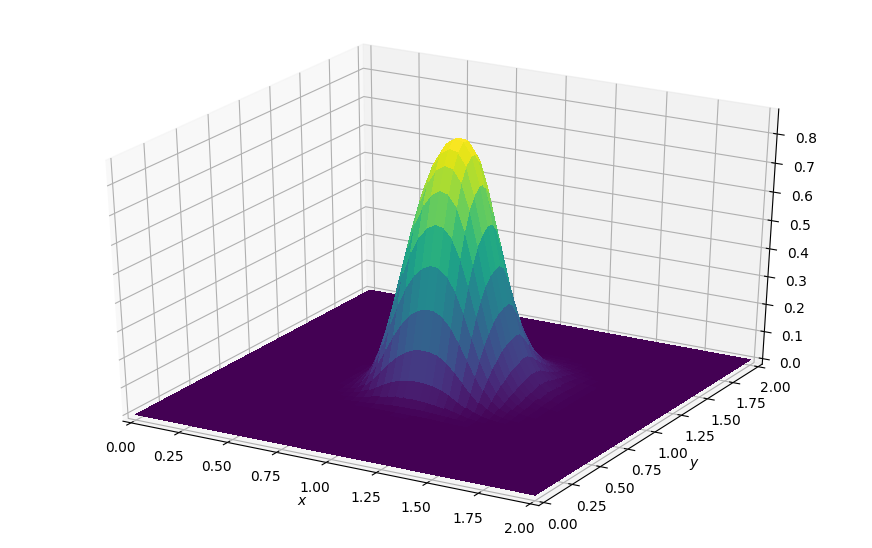

In [9]:
u0(u2) # Reapply the initial condition
diffusionOp(time = time, dt = dt, iter_m = 1, iter_M = 10) # Run the operator

plot_field(u2.data[0, :, :]) # Plot the result for the wave equation

The same PDEs could be solved using other implicit-explicit combination of methods. For example, using Adams-Bashfort for the explicit term $B(u)$ and the trapezoidal method for the implicit term $A(u)$, the equation becomes $\frac{\partial u}{\partial t} = \frac{1}{2} (A(u(t)) + A(u(t+\Delta t)) + 3 B(u(t)) - B(u(t-\Delta t)))$.

Operator `Kernel` run in 0.03 s


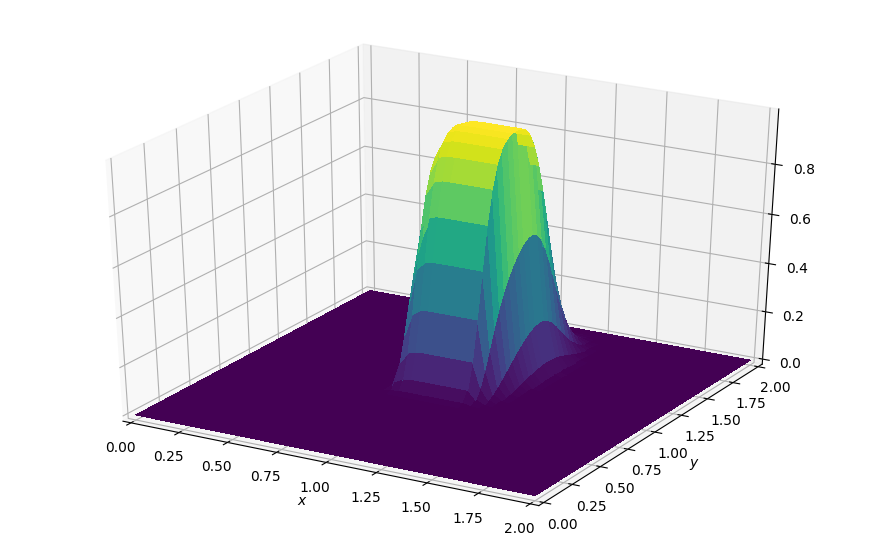

In [10]:
u0(u1)

wavePDE = Eq(u1.dtr + 0.5*(c*(3*u1.dxl - u1.backward.dxl) + v*(u1.dyl + u1.forward.dyl)))
diffusionPDE = Eq(u2.dtr + 0.5*(a * (3*u2.dxl - u2.backward.dxl) - b * (u2.laplace + u2.forward.laplace)))

waveEqs = IterativeMethod.SOR.explicit_expressions(wavePDE)

waveOp = Operator(waveEqs)

waveOp(time = time, dt = dt, iter_m = 0, iter_M = 10)

plot_field(u1.data[0, :, :])